# Lecture 2: Gym

**Dependencies and setup** (this can take a minute or so...)

In [1]:
# !pip install swig

# !pip install rldurham  # latest release
# !pip install git+https://github.com/robert-lieck/rldurham.git@main  # latest main version (typically same as release)
# !pip install git+https://github.com/robert-lieck/rldurham.git@dev  # latest dev version

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""  # disable CUDA (better on Colab/NCC: choose an environment without GPU)

import gymnasium as gym
import rldurham as rld  # Reinforcement Learning Durham package with helper functions

**Basic environment**

In [3]:
env = gym.make('CartPole-v1', render_mode="human")
observation, info = env.reset(seed=42)

for episode in range(10):
    observation, info = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # random action
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

env.close()

**Reinforcement Learning Durham:** _rldurham_ Python package

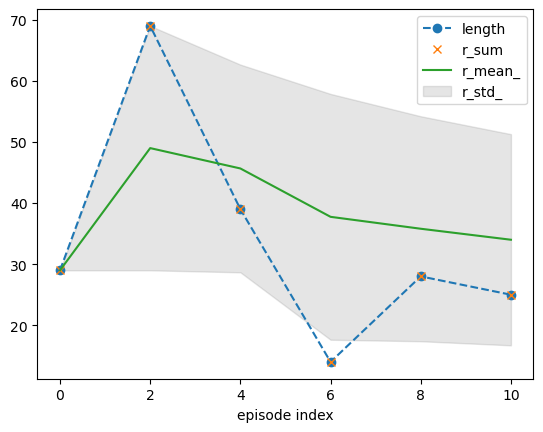

In [4]:
# drop-in for gym.make that enables logging (use render_mode="rgb_array" to enable video rendering)
env = rld.make('CartPole-v1', render_mode="rgb_array")

# record statistics (returned in info) and videos
env = rld.Recorder(
    env,
    smoothing=10,                       # track rolling averages (not required for coursework)
    video=True,                         # enable recording videos
    video_folder="videos",              # folder for videos
    video_prefix="xxxx00-agent-video",  # prefix for videos
    logs=True,                          # keep logs
)

# make reproducible by seeding everything (python, numpy, pytorch, env)
# this also calls env.reset
seed, observation, info = rld.seed_everything(42, env)

# optionally track statistics for plotting
tracker = rld.InfoTracker()

# run episodes
for episode in range(11):
    # recording statistics and video can be switched on and off (video recording is slow!)
    env.info = episode % 2 == 0   # track every other episode (usually tracking every episode is fine)
    env.video = episode % 4 == 0  # you only want to record videos every x episodes (set BEFORE calling reset!)
    #######################################################################
    # this is the same as above
    observation, info = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # Random action
        observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
    #######################################################################
        if done:
            # per-episode statistics are returned by Recorder wrapper in info
            #     'idx': index/count of the episode
            #     'length': length of the episode
            #     'r_sum': sum of rewards in episode
            #     'r_mean': mean of rewards in episode
            #     'r_std': standard deviation of rewards in episode
            #     'length_': average `length' over smoothing window
            #     'r_sum_': reward sum over smoothing window (not the average)
            #     'r_mean_': average reward sum per episode over smoothing window (i.e. average of `r_sum')
            #     'r_std_': standard deviation of reward sum per episode over smoothing window

            # InfoTracker turns these into arrays over time
            tracker.track(info)
            print(tracker.info)

            # some plotting functionality is provided (this will refresh in notebooks)
            #  - combinations of ``r_mean`` and ``r_std`` or ``r_mean_`` and ``r_std_`` are most insightful
            #  - for `CartPole`, ``length`` and ``r_sum`` are the same as there is a unit reward for each
            #    time step of successful balancing
            tracker.plot(r_mean_=True, r_std_=True,
                         length=dict(linestyle='--', marker='o'),
                         r_sum=dict(linestyle='', marker='x'))

# don't forget to close environment (e.g. triggers last video save)
env.close()

# write log file (for coursework)
env.write_log(folder="logs", file="xxxx00-agent-log.txt")

In [5]:
# print log file
import pandas as pd
log_file = "logs/xxxx00-agent-log.txt"
print(f"log file: {log_file}")
print(pd.read_csv(log_file, sep="\t").head())

log file: logs/xxxx00-agent-log.txt
   count  reward_sum  squared_reward_sum  length
0      0        29.0                29.0      29
1      1        17.0                17.0      17
2      2        69.0                69.0      69
3      3        15.0                15.0      15
4      4        39.0                39.0      39


In [6]:
# show video
import os, re
from ipywidgets import Video
video_file = "videos/" + sorted(f for f in os.listdir("videos") if re.match(r".+episode=4.+\.mp4", f))[0]
print(f"video file: {video_file}")
Video.from_file(video_file)

video file: videos/xxxx00-agent-video,episode=4,score=39.0.mp4


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free...')

**Different environments**

In [7]:
## render mode
# rm = 'human'     # for rendering in separate window
rm = 'rgb_array' # for recording videos or rendering in notebook
# rm = None        # no rendering

## select environment
env = rld.make('CartPole-v1', render_mode=rm)              # easy discrete
# env = rld.make('FrozenLake-v1', render_mode=rm)            # easy discrete
# env = rld.make('LunarLander-v3', render_mode=rm)           # discrete
# env = rld.make('ALE/Breakout-v5', render_mode=rm)          # discrete (atari)
# env = rld.make('Pong-ram-v4', render_mode=rm)              # discrete (atari)
# env = rld.make('Gravitar-ram-v4', render_mode=rm)          # hard discrete (atari)
#
# env = rld.make('Pendulum-v1', render_mode=rm)              # easy continuous
# env = rld.make('LunarLanderContinuous-v3', render_mode=rm) # continuous
# env = rld.make('BipedalWalker-v3', render_mode=rm)         # continuous
# env = rld.make('BipedalWalkerHardcore-v3', render_mode=rm) # hard continuous

## wrap for stats and video recording (requires render_mode='rgb_array')
# env = rld.Recorder(env, video=True)
# env.video = False  # deactivate

## there are many more!
# gym.pprint_registry()

# get some info
discrete_act = hasattr(env.action_space, 'n')
discrete_obs = hasattr(env.observation_space, 'n')
act_dim = env.action_space.n if discrete_act else env.action_space.shape[0]
obs_dim = env.observation_space.n if discrete_obs else env.observation_space.shape[0]
discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env)  # same
print(f"The environment has "
      f"{act_dim}{(f' discrete' if discrete_act else f'-dimensional continuous')} actions and "
      f"{obs_dim}{(f' discrete' if discrete_obs else f'-dimensional continuous')} observations.")
print('The maximum timesteps is: {}'.format(env.spec.max_episode_steps))

print("\nrldurham helper function:")
rld.env_info(env, print_out=True)

The environment has 2 discrete actions and 4-dimensional continuous observations.
The maximum timesteps is: 500

rldurham helper function:
actions are discrete with 2 dimensions/#actions
observations are continuous with 4 dimensions/#observations
maximum timesteps is: 500


(True, False, np.int64(2), 4)

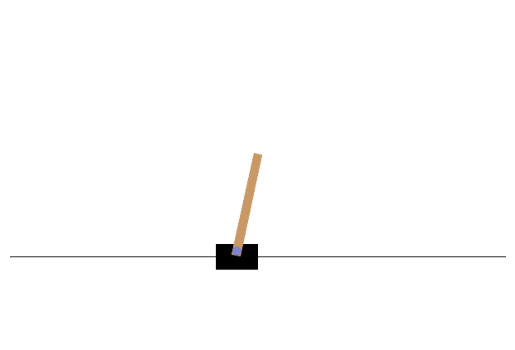

In [8]:
for episode in range(1):
    observation, info = env.reset()
    if env.render_mode == 'rgb_array':
        rld.render(env, clear=True)
    done = False
    for step in range(200):
        action = env.action_space.sample()  # random action
        observation, reward, terminated, truncated, info = env.step(action)
        if env.render_mode == 'rgb_array':
            rld.render(env, clear=True)
        done = terminated or truncated
        if done:
            break
env.close()

**Training an agent**

In [9]:
import numpy as np
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('The device is: {}'.format(device))
if device.type != 'cpu': print('It\'s recommended to train on the cpu for this')

print('\nrldurham helper function:')
rld.check_device()

The device is: cpu

rldurham helper function:
The device is: cpu (as recommended)


device(type='cpu')

In [10]:
class Agent(torch.nn.Module):
    def __init__(self, env):
        super().__init__()
        self.discrete_act, self.discrete_obs, self.act_dim, self.obs_dim = rld.env_info(env)

    def prob_action(self, obs):
        return np.ones(self.act_dim)/self.act_dim

    def sample_action(self, prob):
        if self.discrete_act:
            return np.random.choice(self.act_dim, p=prob)
        else:
            return np.random.uniform(-1.0, 1.0, size=self.act_dim)

    def train(self):
        return

    def put_data(self, item):
        return

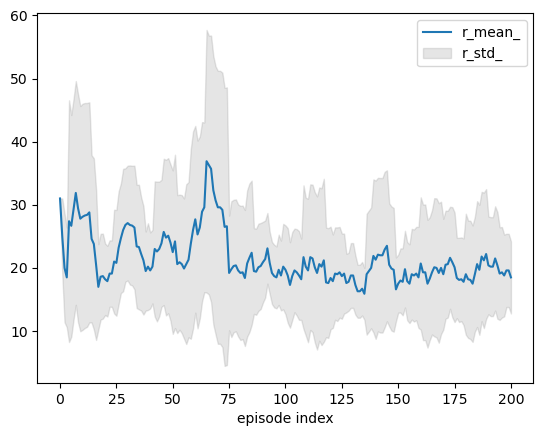

In [11]:
# init environment
env = rld.make('CartPole-v1')
env = rld.Recorder(env, smoothing=10)

# seed
rld.seed_everything(seed=42, env=env)

# init agent
agent = Agent(env)

# training procedure
tracker = rld.InfoTracker()
for episode in range(201):
    obs, info = env.reset()
    done = False

    # get episode
    while not done:
        # select action
        prob = agent.prob_action(obs)
        action = agent.sample_action(prob)

        # take action in environment
        next_obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        agent.put_data((reward, prob[action] if agent.discrete_act else None))
        obs = next_obs

    # track and plot
    tracker.track(info)
    if episode % 10 == 0:
        tracker.plot(r_mean_=True, r_std_=True)

    # update agent's policy
    agent.train()
env.close()

**REINFORCE agent example**
This code is based on: https://github.com/seungeunrho/minimalRL

Note: these implementations are good to study, although most are for discrete action spaces

In [12]:
# this is an implementation of REINFORCE (taught in lecture 8) - one of the simplest classical policy gradient methods
# this will only work for simple discrete control problems like cart pole or (slowly) lunar lander discrete
plot_interval = 50
video_every = 500
max_episodes = 5000


class Agent(torch.nn.Module):
    def __init__(self, env):
        super().__init__()
        discrete_act, discrete_obs, act_dim, obs_dim = rld.env_info(env)
        if not discrete_act:
            raise RuntimeError("REINFORCE only works for discrete action spaces")
        self.data = []
        self.fc1 = torch.nn.Linear(obs_dim, 128)
        self.fc2 = torch.nn.Linear(128, act_dim)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0002)

    def sample_action(self, prob):
        m = torch.Categorical(prob)
        a = m.sample()
        return a.item()

    def prob_action(self, s):
        x = torch.F.relu(self.fc1(torch.from_numpy(s).float()))
        return torch.F.softmax(self.fc2(x), dim=0)

    def put_data(self, item):
        self.data.append(item)

    def train(self):
        R = 0
        self.optimizer.zero_grad()
        for r, prob in self.data[::-1]:
            R = r + 0.98 * R
            loss = -torch.log(prob) * R
            loss.backward()
        self.optimizer.step()
        self.data = []

**Custom environments (here: multi-armed bandits)**

In [13]:
# one armed bandits are slot machines where you can win or loose money
# some casinos tune them, so some machines are less successful (the probability distribution of winning)
# the machines also dish out varying rewards (the reward distribution)
# so basically each machine has some probability of dishing out £ reward (p_dist doesn't need to sum to 1) else it gives £0

class BanditEnv(gym.Env):

    def __init__(self, p_dist=[0.4,0.2,0.1,0.1,0.1,0.7], r_dist=[1,0.1,2,0.5,6,70]):

        self.p_dist = p_dist
        self.r_dist = r_dist

        self.n_bandits = len(p_dist)
        self.action_space = gym.spaces.Discrete(self.n_bandits)
        self.observation_space = gym.spaces.Discrete(1)

    def step(self, action):
        assert self.action_space.contains(action)

        reward = -25
        terminated = True
        truncated = False

        if np.random.uniform() < self.p_dist[action]:
            if not isinstance(self.r_dist[action], list):
                reward += self.r_dist[action]
            else:
                reward += np.random.normal(self.r_dist[action][0], self.r_dist[action][1])

        return np.zeros(1), reward, terminated, truncated, {}

    def reset(self, seed=None, options=None):
        if seed is not None:
            self.np_random, seed = gym.utils.seeding.np_random(seed)
        return np.zeros(1), {}

    def render(self):
        pass

In [14]:
# initialise
discrete = True
env = BanditEnv()
obs_dim = 1
act_dim = len(env.p_dist)
env.spec = gym.envs.registration.EnvSpec('BanditEnv-v0', max_episode_steps=5)
max_episodes = 1000

for episode in range(10):
    observation, info = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()  # random action
        observation, reward, terminated, truncated, info = env.step(action)
        print(action, reward)
        done = terminated or truncated

env.close()

0 -25
4 -25
2 -23
5 45
0 -25
1 -25
1 -25
2 -25
3 -25
1 -25


In [15]:
gym.register(id="BanditEnv-v0", entry_point=BanditEnv)
gym.pprint_registry()

===== classic_control =====
Acrobot-v1                        CartPole-v0                       CartPole-v1
MountainCar-v0                    MountainCarContinuous-v0          Pendulum-v1
===== phys2d =====
phys2d/CartPole-v0                phys2d/CartPole-v1                phys2d/Pendulum-v0
===== box2d =====
BipedalWalker-v3                  BipedalWalkerHardcore-v3          CarRacing-v3
LunarLander-v3                    LunarLanderContinuous-v3
===== toy_text =====
Blackjack-v1                      CliffWalking-v0                   FrozenLake-v1
FrozenLake8x8-v1                  Taxi-v3
===== tabular =====
tabular/Blackjack-v0              tabular/CliffWalking-v0
===== mujoco =====
Ant-v2                            Ant-v3                            Ant-v4
Ant-v5                            HalfCheetah-v2                    HalfCheetah-v3
HalfCheetah-v4                    HalfCheetah-v5                    Hopper-v2
Hopper-v3                         Hopper-v4                         Ho